In [13]:
from ortools.sat.python import cp_model
import pandas as pd

# ----------------------------
# Setup
# ----------------------------
names = ['ron', 'ronal', 'ronan', 'madhu', 'yash', 'yashas', 'sid', 'jacob', 'simon', 'marty', 
         'austin', 'dylan', 'david', 'andre', 'delwin', 'john', 'rodrick', 'neehal', 'naveen',
         'mateo', 'clement', 'vivek']
num_weeks = 19

weekly_count = {
    'deck_1': 2,
    'deck_0': 4,
    'kitchen': 6,
    'deck_brush': 3,
    'bathroom_2': 3,
    'bathroom_3': 2,
    'stairs': 2
}

# Compute theoretical per-person target ±1
num_people = len(names)
extra_per_week = num_people - sum(weekly_count.values())
per_week_actual = weekly_count.copy()
order = list(weekly_count.keys())
for i in range(extra_per_week):
    per_week_actual[order[i % len(order)]] += 1

exact = {k: (v * num_weeks) / num_people for k, v in per_week_actual.items()}
target_per_person = {k: int(round(exact[k])) for k in exact}  # ±1 allowed
tasks = list(weekly_count.keys())

# ----------------------------
# CP-SAT Model
# ----------------------------
model = cp_model.CpModel()
x = {}
for p in names:
    for w in range(num_weeks):
        for t in tasks:
            x[p, w, t] = model.NewBoolVar(f"x_{p}_{w}_{t}")

# Weekly counts constraint
for w in range(num_weeks):
    for t in tasks:
        model.Add(sum(x[p, w, t] for p in names) == weekly_count[t])

# One cleanup per person per week
for p in names:
    for w in range(num_weeks):
        model.Add(sum(x[p, w, t] for t in tasks) == 1)

# Per-person target constraint ±1
for p in names:
    for t in tasks:
        total = sum(x[p, w, t] for w in range(num_weeks))
        model.Add(total >= target_per_person[t] - 1)
        model.Add(total <= target_per_person[t] + 1)

# Consecutive repetition constraint: max 1 week repeat allowed
for p in names:
    for w in range(num_weeks - 2):
        for t in tasks:
            # sum of three consecutive weeks ≤ 2
            model.Add(x[p, w, t] + x[p, w + 1, t] + x[p, w + 2, t] <= 2)

# ----------------------------
# Solver
# ----------------------------
solver = cp_model.CpSolver()
status = solver.Solve(model)

# ----------------------------
# Output
# ----------------------------
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    schedule = []
    for w in range(num_weeks):
        week_assign = {}
        for p in names:
            for t in tasks:
                if solver.Value(x[p, w, t]):
                    week_assign[p] = t
                    break
        schedule.append(week_assign)
    df_schedule = pd.DataFrame(schedule)
    print("Schedule (first 5 weeks):")
    print(df_schedule.head())
    
    # Compute per-person totals
    per_person_totals = {}
    for p in names:
        counts = {t: 0 for t in tasks}
        for w in range(num_weeks):
            t = schedule[w][p]
            counts[t] += 1
        per_person_totals[p] = counts
    
    print("\nPer-person cleanup counts over the semester:")
    for p, c in per_person_totals.items():
        print(f"{p}: {c}")
else:
    print("No solution found")


Schedule (first 5 weeks):
          ron    ronal       ronan       madhu        yash      yashas  \
0      deck_1   stairs  bathroom_2      deck_1      stairs  deck_brush   
1      deck_0   deck_1  bathroom_3  deck_brush  bathroom_2     kitchen   
2     kitchen  kitchen     kitchen      deck_1  bathroom_3      stairs   
3  bathroom_2   deck_0     kitchen  bathroom_2  deck_brush     kitchen   
4     kitchen  kitchen  deck_brush  bathroom_3     kitchen  bathroom_2   

          sid       jacob    simon       marty  ...       david       andre  \
0      deck_0     kitchen   deck_0  deck_brush  ...  bathroom_2     kitchen   
1      deck_0  bathroom_2   stairs  bathroom_2  ...      deck_0      deck_1   
2     kitchen      deck_0  kitchen  bathroom_3  ...     kitchen  bathroom_2   
3  bathroom_2      stairs   deck_0      deck_0  ...      deck_0     kitchen   
4  bathroom_2     kitchen   deck_0     kitchen  ...      deck_0  bathroom_3   

       delwin        john     rodrick      neehal     

In [14]:
# ----------------------------
# Verification
# ----------------------------
print("\nVerification:")

for p in names:
    person_schedule = [schedule[w][p] for w in range(num_weeks)]
    
    # Check total cleanups
    total_weeks = len(person_schedule)
    if total_weeks != num_weeks:
        print(f"{p}: ERROR - total weeks = {total_weeks}, expected {num_weeks}")
    
    # Count per cleanup
    counts = {}
    for t in tasks:
        counts[t] = person_schedule.count(t)
    
    # Check consecutive repeats
    consecutive_repeats = {}
    prev = None
    streak = 1
    for t in person_schedule:
        if t == prev:
            streak += 1
        else:
            if prev is not None and streak > 1:
                consecutive_repeats[prev] = max(consecutive_repeats.get(prev, 0), streak)
            streak = 1
        prev = t
    # Handle last streak
    if streak > 1:
        consecutive_repeats[prev] = max(consecutive_repeats.get(prev, 0), streak)
    
    print(f"{p}: total cleanups = {sum(counts.values())}, per-task counts = {counts}")
    if consecutive_repeats:
        print(f"    Consecutive repeats: {consecutive_repeats}")
    else:
        print("    No consecutive repeats")



Verification:
ron: total cleanups = 19, per-task counts = {'deck_1': 2, 'deck_0': 4, 'kitchen': 6, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 1}
    Consecutive repeats: {'kitchen': 2, 'deck_0': 2, 'deck_brush': 2}
ronal: total cleanups = 19, per-task counts = {'deck_1': 2, 'deck_0': 4, 'kitchen': 4, 'deck_brush': 2, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 3}
    No consecutive repeats
ronan: total cleanups = 19, per-task counts = {'deck_1': 1, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 2, 'bathroom_3': 3, 'stairs': 2}
    Consecutive repeats: {'kitchen': 2, 'deck_0': 2}
madhu: total cleanups = 19, per-task counts = {'deck_1': 2, 'deck_0': 2, 'kitchen': 4, 'deck_brush': 3, 'bathroom_2': 4, 'bathroom_3': 2, 'stairs': 2}
    Consecutive repeats: {'kitchen': 2, 'bathroom_2': 2}
yash: total cleanups = 19, per-task counts = {'deck_1': 2, 'deck_0': 2, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 2, 'bathroom_3': 3, 'stairs': 2}
    Consecutive repeats: {

In [17]:
from ortools.sat.python import cp_model
import pandas as pd
import random
from collections import defaultdict

# ----------------------------
# Setup
# ----------------------------
names = ['ron', 'ronal', 'ronan', 'madhu', 'yash', 'yashas', 'sid', 'jacob', 'simon', 'marty', 
         'austin', 'dylan', 'david', 'andre', 'delwin', 'john', 'rodrick', 'neehal', 'naveen',
         'mateo', 'clement', 'vivek']
num_weeks = 19

weekly_count = {
    'deck_1': 2,
    'deck_0': 4,
    'kitchen': 6,
    'deck_brush': 3,
    'bathroom_2': 3,
    'bathroom_3': 2,
    'stairs': 2
}

# Compute theoretical per-person target ±1
num_people = len(names)
extra_per_week = num_people - sum(weekly_count.values())
per_week_actual = weekly_count.copy()
order = list(weekly_count.keys())
for i in range(extra_per_week):
    per_week_actual[order[i % len(order)]] += 1

exact = {k: (v * num_weeks) / num_people for k, v in per_week_actual.items()}
target_per_person = {k: int(round(exact[k])) for k in exact}  # ±1 allowed
tasks = list(weekly_count.keys())

# ----------------------------
# CP-SAT Model
# ----------------------------
model = cp_model.CpModel()
x = {}
for p in names:
    for w in range(num_weeks):
        for t in tasks:
            x[p, w, t] = model.NewBoolVar(f"x_{p}_{w}_{t}")

# Weekly counts constraint
for w in range(num_weeks):
    for t in tasks:
        model.Add(sum(x[p, w, t] for p in names) == weekly_count[t])

# One cleanup per person per week
for p in names:
    for w in range(num_weeks):
        model.Add(sum(x[p, w, t] for t in tasks) == 1)

# Per-person target constraint ±1
for p in names:
    for t in tasks:
        total = sum(x[p, w, t] for w in range(num_weeks))
        model.Add(total >= target_per_person[t] - 1)
        model.Add(total <= target_per_person[t] + 1)

# Consecutive repetition constraint: max 2 consecutive weeks
for p in names:
    for w in range(num_weeks - 2):
        for t in tasks:
            model.Add(x[p, w, t] + x[p, w + 1, t] + x[p, w + 2, t] <= 2)

# ----------------------------
# Solution collector
# ----------------------------
class SolutionCollector(cp_model.CpSolverSolutionCallback):
    def __init__(self, x_vars, names, weeks, tasks, max_solutions=500):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.x_vars = x_vars
        self.names = names
        self.weeks = weeks
        self.tasks = tasks
        self.solutions = []
        self.max_solutions = max_solutions

    def on_solution_callback(self):
        if len(self.solutions) >= self.max_solutions:
            self.StopSearch()
            return
        schedule = []
        for w in range(self.weeks):
            week_assign = {}
            for p in self.names:
                for t in self.tasks:
                    if self.Value(self.x_vars[p, w, t]):
                        week_assign[p] = t
                        break
            schedule.append(week_assign)
        self.solutions.append(schedule)

# ----------------------------
# Solve and collect solutions
# ----------------------------
solver = cp_model.CpSolver()
collector = SolutionCollector(x, names, num_weeks, tasks, max_solutions=500)
solver.SearchForAllSolutions(model, collector)

print(f"Collected {len(collector.solutions)} solutions")

# ----------------------------
# Build week-by-week tree for random traversal
# ----------------------------
def assign_key(assign):
    return tuple(sorted(assign.items()))

week_tree = defaultdict(lambda: defaultdict(set))
for sol in collector.solutions:
    for w in range(num_weeks - 1):
        parent_key = assign_key(sol[w])
        child_key = assign_key(sol[w + 1])
        week_tree[w + 1][parent_key].add(child_key)

def random_schedule_from_tree(week_tree, solutions, weeks):
    # Randomly pick week 1 assignment
    week1 = random.choice(solutions)[0]
    schedule = [week1]
    current_key = assign_key(week1)

    for w in range(1, weeks):
        children = week_tree[w].get(current_key, None)
        if not children:
            break
        child_key = random.choice(list(children))
        schedule.append(dict(child_key))
        current_key = child_key
    return schedule

# ----------------------------
# Example usage
# ----------------------------
if collector.solutions:
    schedule = random_schedule_from_tree(week_tree, collector.solutions, num_weeks)
    df_schedule = pd.DataFrame(schedule)
    print("Schedule (first 5 weeks):")
    print(df_schedule.head())

    # Compute per-person totals
    per_person_totals = {}
    for p in names:
        counts = {t: 0 for t in tasks}
        for w in range(num_weeks):
            t = schedule[w][p]
            counts[t] += 1
        per_person_totals[p] = counts

    print("\nPer-person cleanup counts over the semester:")
    for p, c in per_person_totals.items():
        print(f"{p}: {c}")
else:
    print("No solutions found")


Collected 500 solutions
Schedule (first 5 weeks):
          ron       ronal       ronan       madhu        yash      yashas  \
0  deck_brush     kitchen     kitchen      deck_0  bathroom_3  bathroom_2   
1  bathroom_2     kitchen  deck_brush      deck_1      deck_0  deck_brush   
2  deck_brush      deck_0     kitchen  bathroom_2     kitchen      stairs   
3      deck_1     kitchen      deck_0      stairs      deck_0  bathroom_2   
4     kitchen  deck_brush  bathroom_2  bathroom_3  bathroom_2  bathroom_3   

          sid       jacob       simon       marty  ...       david  \
0  bathroom_2  deck_brush  deck_brush     kitchen  ...      deck_1   
1      stairs  deck_brush     kitchen  bathroom_3  ...     kitchen   
2      deck_0      deck_1  bathroom_3     kitchen  ...  bathroom_3   
3     kitchen     kitchen     kitchen      deck_0  ...  deck_brush   
4      deck_0      stairs  deck_brush     kitchen  ...      stairs   

        andre      delwin        john     rodrick      neehal     

In [20]:
current_keys = [assign_key(sol[0]) for sol in collector.solutions]  # all possible week1 keys
for w in range(1, num_weeks):
    next_keys = set()
    for ck in current_keys:
        next_keys.update(week_tree[w].get(ck, []))
    print(f"Week {w+1} has {len(next_keys)} possible assignments")
    current_keys = next_keys  # propagate to next week


Week 2 has 444 possible assignments
Week 3 has 443 possible assignments
Week 4 has 442 possible assignments
Week 5 has 441 possible assignments
Week 6 has 445 possible assignments
Week 7 has 447 possible assignments
Week 8 has 442 possible assignments
Week 9 has 441 possible assignments
Week 10 has 445 possible assignments
Week 11 has 446 possible assignments
Week 12 has 442 possible assignments
Week 13 has 444 possible assignments
Week 14 has 443 possible assignments
Week 15 has 442 possible assignments
Week 16 has 442 possible assignments
Week 17 has 443 possible assignments
Week 18 has 441 possible assignments
Week 19 has 443 possible assignments


In [27]:
import random

# Function to convert assignment dict to a hashable key
def assign_key(assign):
    return tuple(sorted(assign.items()))

def traverse_random_options(week_tree, solutions, num_weeks):
    # Randomly pick week 1
    week1 = random.choice(solutions)[0]
    schedule = [week1]
    current_key = assign_key(week1)
    print(f"Week 1 selected assignment: {week1}")

    for w in range(1, num_weeks):
        # Possible children for this week based on previous week
        children = week_tree[w].get(current_key, None)
        if not children or len(children) == 0:
            print(f"Week {w+1}: No feasible assignments remaining!")
            break
        print(f"Week {w+1}: {len(children)} feasible options")
        # Randomly pick one for this week
        child_key = random.choice(list(children))
        schedule.append(dict(child_key))
        current_key = child_key  # update key for next week

    return schedule

# Example usage
full_schedule = traverse_random_options(week_tree, collector.solutions, num_weeks)


Week 1 selected assignment: {'ron': 'kitchen', 'ronal': 'bathroom_2', 'ronan': 'kitchen', 'madhu': 'stairs', 'yash': 'deck_0', 'yashas': 'deck_brush', 'sid': 'bathroom_2', 'jacob': 'kitchen', 'simon': 'deck_0', 'marty': 'kitchen', 'austin': 'bathroom_3', 'dylan': 'bathroom_2', 'david': 'deck_0', 'andre': 'kitchen', 'delwin': 'stairs', 'john': 'deck_brush', 'rodrick': 'deck_1', 'neehal': 'deck_brush', 'naveen': 'bathroom_3', 'mateo': 'deck_0', 'clement': 'deck_1', 'vivek': 'kitchen'}
Week 2: 1 feasible options
Week 3: 1 feasible options
Week 4: 1 feasible options
Week 5: 1 feasible options
Week 6: 1 feasible options
Week 7: 1 feasible options
Week 8: 1 feasible options
Week 9: 1 feasible options
Week 10: 1 feasible options
Week 11: 1 feasible options
Week 12: 1 feasible options
Week 13: 1 feasible options
Week 14: 1 feasible options
Week 15: 1 feasible options
Week 16: 1 feasible options
Week 17: 1 feasible options
Week 18: 1 feasible options
Week 19: 1 feasible options


In [28]:
import random
from collections import defaultdict

# --- Step 1: Build week tree ---
def assign_key(assign):
    return tuple(sorted(assign.items()))

week_tree = defaultdict(lambda: defaultdict(set))
for sol in collector.solutions:  # collector.solutions from CP-SAT
    for w in range(num_weeks - 1):
        parent_key = assign_key(sol[w])
        child_key = assign_key(sol[w + 1])
        week_tree[w + 1][parent_key].add(child_key)

# --- Step 2: Define scoring function ---
def score_path(schedule, kitchen_target, deck0_target):
    """
    Count how many people exceed ±1 deviation in kitchen/deck0.
    Return higher score for fewer deviations.
    """
    num_people = len(schedule[0])
    per_person_counts = {p: {'kitchen': 0, 'deck_0': 0} for p in schedule[0]}
    consecutive_violations = 0

    for w, week in enumerate(schedule):
        # consecutive repeat check
        if w >= 1:
            for p in week:
                if week[p] == schedule[w-1][p]:
                    consecutive_violations += 1
        for p in week:
            if week[p] == 'kitchen':
                per_person_counts[p]['kitchen'] += 1
            elif week[p] == 'deck_0':
                per_person_counts[p]['deck_0'] += 1

    # count violations: >1 deviation from target
    violation_count = 0
    for p in per_person_counts:
        if abs(per_person_counts[p]['kitchen'] - kitchen_target) > 1:
            violation_count += 1
        if abs(per_person_counts[p]['deck_0'] - deck0_target) > 1:
            violation_count += 1

    # penalize consecutive repeats heavily
    return -(violation_count + 10 * consecutive_violations)  # higher is better

# --- Step 3: Traverse tree recursively ---
def traverse_best(week_tree, week, current_key, schedule_so_far, best_score, best_path, kitchen_target, deck0_target):
    if week == num_weeks:
        score = score_path(schedule_so_far, kitchen_target, deck0_target)
        if score > best_score[0]:
            best_score[0] = score
            best_path[0] = schedule_so_far.copy()
        return

    children = week_tree[week].get(current_key, None)
    if not children:
        return

    for child_key in children:
        child_assign = dict(child_key)
        traverse_best(
            week_tree,
            week + 1,
            child_key,
            schedule_so_far + [child_assign],
            best_score,
            best_path,
            kitchen_target,
            deck0_target
        )

# --- Step 4: Try all week 1 solutions ---
best_score = [-float('inf')]
best_path = [None]

kitchen_target = target_per_person['kitchen']  # ideal
deck0_target = target_per_person['deck_0']

for sol in collector.solutions:
    week1_assign = sol[0]
    traverse_best(
        week_tree,
        1,
        assign_key(week1_assign),
        [week1_assign],
        best_score,
        best_path,
        kitchen_target,
        deck0_target
    )

# --- Step 5: Output best schedule ---
import pandas as pd
if best_path[0] is not None:
    df_best = pd.DataFrame(best_path[0])
    print("Best schedule found:")
    print(df_best.head())
else:
    print("No valid schedule found")


Best schedule found:
          ron       ronal       ronan       madhu        yash      yashas  \
0     kitchen      deck_0     kitchen     kitchen     kitchen      deck_1   
1      deck_1  bathroom_2  deck_brush      deck_1     kitchen      deck_0   
2     kitchen     kitchen  deck_brush  deck_brush  bathroom_2  bathroom_3   
3  deck_brush      deck_0     kitchen      deck_0  deck_brush     kitchen   
4      deck_1  bathroom_2  bathroom_2  deck_brush     kitchen      deck_0   

          sid       jacob       simon       marty  ...       david  \
0      stairs  deck_brush  bathroom_2  bathroom_3  ...  bathroom_2   
1      deck_0  bathroom_3      stairs  deck_brush  ...      deck_0   
2      deck_0      stairs  bathroom_3      deck_0  ...     kitchen   
3  bathroom_2     kitchen     kitchen     kitchen  ...      deck_1   
4     kitchen  deck_brush      deck_0      deck_0  ...     kitchen   

        andre      delwin        john     rodrick      neehal      naveen  \
0  bathroom_2     

In [29]:
# Assume best_path[0] is already computed
best_schedule = best_path[0]

# --- Per-person totals ---
per_person_totals = {}
for p in names:
    counts = {t: 0 for t in tasks}
    for w in range(num_weeks):
        t = best_schedule[w][p]
        counts[t] += 1
    per_person_totals[p] = counts

print("\nPer-person cleanup counts over the semester:")
for p, c in per_person_totals.items():
    print(f"{p}: {c}")

# --- Consecutive repetitions ---
consec_repeats = {}
for p in names:
    repeats = {}
    for t in tasks:
        repeats[t] = 0
    for w in range(1, num_weeks):
        if best_schedule[w][p] == best_schedule[w-1][p]:
            repeats[best_schedule[w][p]] += 1
    consec_repeats[p] = repeats

print("\nConsecutive repeats per person:")
for p, r in consec_repeats.items():
    # Only print if there's any repetition
    nonzero = {t: cnt for t, cnt in r.items() if cnt > 0}
    if nonzero:
        print(f"{p}: {nonzero}")



Per-person cleanup counts over the semester:
ron: {'deck_1': 3, 'deck_0': 2, 'kitchen': 6, 'deck_brush': 2, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 2}
ronal: {'deck_1': 1, 'deck_0': 4, 'kitchen': 6, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 2, 'stairs': 1}
ronan: {'deck_1': 1, 'deck_0': 2, 'kitchen': 6, 'deck_brush': 4, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 2}
madhu: {'deck_1': 3, 'deck_0': 2, 'kitchen': 4, 'deck_brush': 4, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 2}
yash: {'deck_1': 2, 'deck_0': 4, 'kitchen': 4, 'deck_brush': 3, 'bathroom_2': 4, 'bathroom_3': 1, 'stairs': 1}
yashas: {'deck_1': 2, 'deck_0': 4, 'kitchen': 4, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 3}
sid: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 2, 'bathroom_3': 1, 'stairs': 3}
jacob: {'deck_1': 1, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 2}
simon: {'deck_1': 2, 'deck_0': 3, 'kitchen': 4, 'deck_brush': 

ron:
  kitchen: [(17, 18)]
ronal:
  kitchen: [(1, 2)]
  deck_0: [(7, 8)]
madhu:
  kitchen: [(9, 10), (18, 19)]
  deck_0: [(12, 13)]
yash:
  bathroom_2: [(17, 18)]
yashas:
  kitchen: [(6, 7), (16, 17)]
  deck_0: [(9, 10)]
sid:
  kitchen: [(10, 11)]
jacob:
  deck_brush: [(1, 2)]
  bathroom_3: [(13, 14)]
  deck_0: [(16, 17)]
simon:
  deck_1: [(8, 9)]
marty:
  kitchen: [(11, 12)]
austin:
  kitchen: [(5, 6)]
dylan:
  bathroom_3: [(8, 9)]
david:
  kitchen: [(7, 8)]
  deck_0: [(10, 11)]
andre:
  deck_brush: [(9, 10)]
delwin:
  kitchen: [(2, 3)]
rodrick:
  bathroom_2: [(2, 3)]
neehal:
  deck_0: [(1, 2)]
  kitchen: [(11, 12)]
naveen:
  stairs: [(8, 9)]
  deck_brush: [(12, 13)]
  kitchen: [(18, 19)]
mateo:
  bathroom_2: [(4, 5)]
  kitchen: [(16, 17)]
clement:
  deck_0: [(6, 7)]
vivek:
  kitchen: [(1, 2)]
  bathroom_3: [(7, 8)]
  stairs: [(14, 15)]


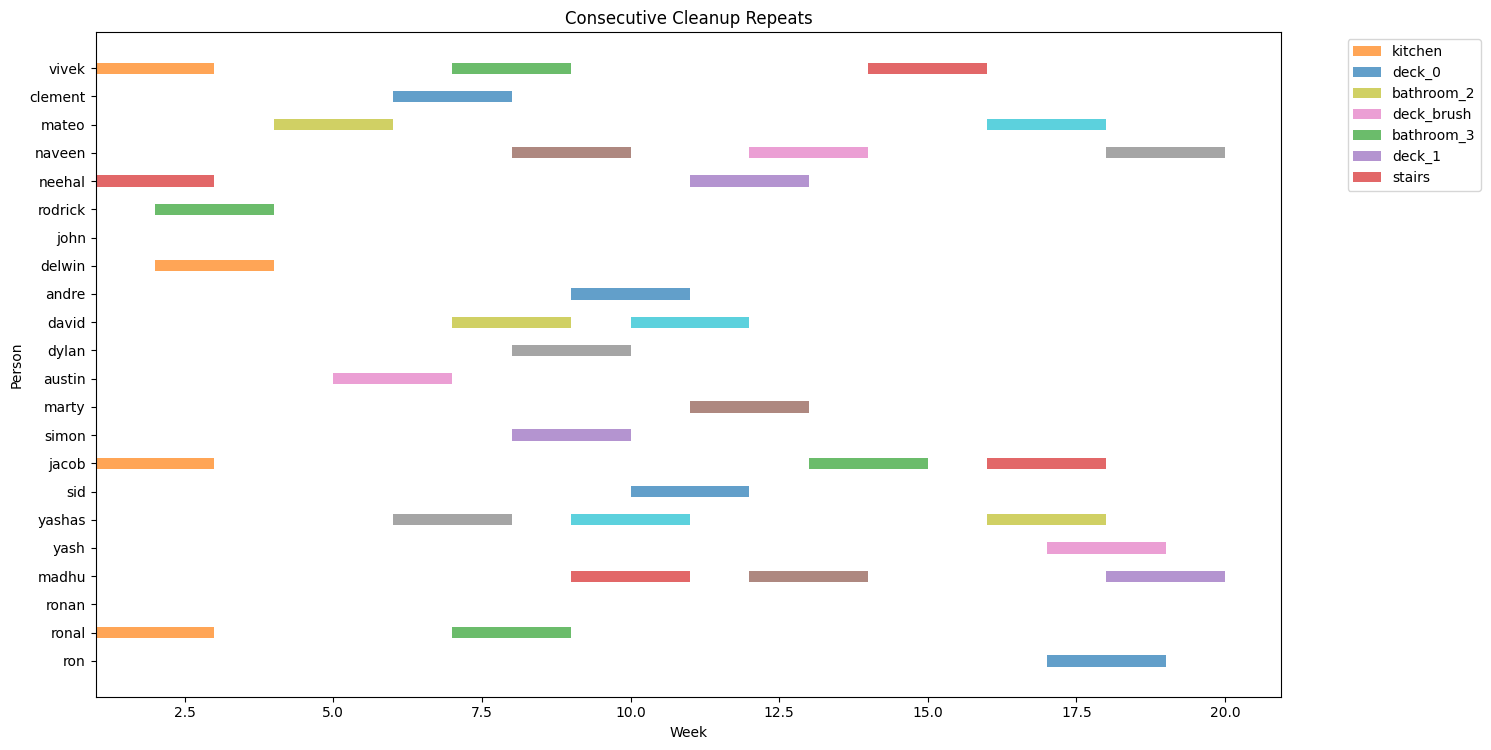

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: df_schedule is your schedule DataFrame with shape (num_weeks, num_people)
# Each cell is the task assigned to that person in that week

def find_consecutive_repeats(df_schedule):
    repeats_info = {}  # person -> {task: [(start_week, end_week), ...]}
    
    for person in df_schedule.columns:
        repeats_info[person] = {}
        prev_task = None
        start_week = None
        
        for week, task in enumerate(df_schedule[person], start=1):
            if task == prev_task:
                # continuing a repeat
                if start_week is None:
                    start_week = week - 1  # start of repeat
            else:
                # repeat ended
                if start_week is not None:
                    if prev_task not in repeats_info[person]:
                        repeats_info[person][prev_task] = []
                    repeats_info[person][prev_task].append((start_week, week - 1))
                    start_week = None
            prev_task = task
        
        # handle repeat till last week
        if start_week is not None:
            if prev_task not in repeats_info[person]:
                repeats_info[person][prev_task] = []
            repeats_info[person][prev_task].append((start_week, len(df_schedule)))
    
    return repeats_info

repeats_info = find_consecutive_repeats(df_schedule)

# Print repeats nicely
for person, tasks in repeats_info.items():
    if tasks:
        print(f"{person}:")
        for task, ranges in tasks.items():
            print(f"  {task}: {ranges}")

# -----------------------------
# Visualization
# -----------------------------
def plot_repeats(df_schedule, repeats_info):
    fig, ax = plt.subplots(figsize=(15, len(df_schedule.columns)*0.3 + 1))
    
    # plot each repeat as a colored block
    y_labels = list(df_schedule.columns)
    for i, person in enumerate(y_labels):
        for task, ranges in repeats_info[person].items():
            for start, end in ranges:
                ax.barh(i, end - start + 1, left=start, height=0.4, label=task, alpha=0.7)
    
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Week")
    ax.set_ylabel("Person")
    ax.set_title("Consecutive Cleanup Repeats")
    
    # unique legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_repeats(df_schedule, repeats_info)


In [31]:
from ortools.sat.python import cp_model
import pandas as pd
import random
from collections import defaultdict

# ----------------------------
# Setup
# ----------------------------
names = ['ron', 'ronal', 'ronan', 'madhu', 'yash', 'yashas', 'sid', 'jacob', 'simon', 'marty', 
         'austin', 'dylan', 'david', 'andre', 'delwin', 'john', 'rodrick', 'neehal', 'naveen',
         'mateo', 'clement', 'vivek']
num_weeks = 19

weekly_count = {
    'deck_1': 2,
    'deck_0': 4,
    'kitchen': 6,
    'deck_brush': 3,
    'bathroom_2': 3,
    'bathroom_3': 2,
    'stairs': 2
}

# Compute theoretical per-person target ±1
num_people = len(names)
extra_per_week = num_people - sum(weekly_count.values())
per_week_actual = weekly_count.copy()
order = list(weekly_count.keys())
for i in range(extra_per_week):
    per_week_actual[order[i % len(order)]] += 1

exact = {k: (v * num_weeks) / num_people for k, v in per_week_actual.items()}
target_per_person = {k: int(round(exact[k])) for k in exact}  # ±1 allowed
tasks = list(weekly_count.keys())

# ----------------------------
# CP-SAT Model
# ----------------------------
model = cp_model.CpModel()
x = {}
for p in names:
    for w in range(num_weeks):
        for t in tasks:
            x[p, w, t] = model.NewBoolVar(f"x_{p}_{w}_{t}")

# Weekly counts constraint
for w in range(num_weeks):
    for t in tasks:
        model.Add(sum(x[p, w, t] for p in names) == weekly_count[t])

# One cleanup per person per week
for p in names:
    for w in range(num_weeks):
        model.Add(sum(x[p, w, t] for t in tasks) == 1)

# Per-person target constraint ±1
for p in names:
    for t in tasks:
        total = sum(x[p, w, t] for w in range(num_weeks))
        model.Add(total >= target_per_person[t] - 1)
        model.Add(total <= target_per_person[t] + 1)

# ----------------------------
# No consecutive repeats
# ----------------------------
for p in names:
    for w in range(num_weeks - 1):
        for t in tasks:
            model.Add(x[p, w, t] + x[p, w + 1, t] <= 1)

# ----------------------------
# Solution collector
# ----------------------------
class SolutionCollector(cp_model.CpSolverSolutionCallback):
    def __init__(self, x_vars, names, weeks, tasks, max_solutions=500):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.x_vars = x_vars
        self.names = names
        self.weeks = weeks
        self.tasks = tasks
        self.solutions = []
        self.max_solutions = max_solutions

    def on_solution_callback(self):
        if len(self.solutions) >= self.max_solutions:
            self.StopSearch()
            return
        schedule = []
        for w in range(self.weeks):
            week_assign = {}
            for p in self.names:
                for t in self.tasks:
                    if self.Value(self.x_vars[p, w, t]):
                        week_assign[p] = t
                        break
            schedule.append(week_assign)
        self.solutions.append(schedule)

# ----------------------------
# Solve and collect solutions
# ----------------------------
solver = cp_model.CpSolver()
collector = SolutionCollector(x, names, num_weeks, tasks, max_solutions=500)
solver.SearchForAllSolutions(model, collector)

print(f"Collected {len(collector.solutions)} solutions")

# ----------------------------
# Build week-by-week tree for random traversal
# ----------------------------
def assign_key(assign):
    return tuple(sorted(assign.items()))

week_tree = defaultdict(lambda: defaultdict(set))
for sol in collector.solutions:
    for w in range(num_weeks - 1):
        parent_key = assign_key(sol[w])
        child_key = assign_key(sol[w + 1])
        week_tree[w + 1][parent_key].add(child_key)

def random_schedule_from_tree(week_tree, solutions, weeks):
    # Randomly pick week 1 assignment
    week1 = random.choice(solutions)[0]
    schedule = [week1]
    current_key = assign_key(week1)

    for w in range(1, weeks):
        children = week_tree[w].get(current_key, None)
        if not children:
            break
        child_key = random.choice(list(children))
        schedule.append(dict(child_key))
        current_key = child_key
    return schedule

# ----------------------------
# Example usage
# ----------------------------
if collector.solutions:
    schedule = random_schedule_from_tree(week_tree, collector.solutions, num_weeks)
    df_schedule = pd.DataFrame(schedule)
    print("Schedule (first 5 weeks):")
    print(df_schedule.head())

    # Compute per-person totals
    per_person_totals = {}
    for p in names:
        counts = {t: 0 for t in tasks}
        for w in range(num_weeks):
            t = schedule[w][p]
            counts[t] += 1
        per_person_totals[p] = counts

    print("\nPer-person cleanup counts over the semester:")
    for p, c in per_person_totals.items():
        print(f"{p}: {c}")
else:
    print("No solutions found")


Collected 500 solutions
Schedule (first 5 weeks):
          ron       ronal    ronan       madhu        yash      yashas  \
0      stairs  bathroom_2  kitchen  bathroom_3      deck_0      deck_1   
1     kitchen      deck_0   deck_0  bathroom_2     kitchen  deck_brush   
2  deck_brush  bathroom_2  kitchen     kitchen  bathroom_2      stairs   
3     kitchen      stairs   deck_0  bathroom_2     kitchen     kitchen   
4  deck_brush     kitchen  kitchen      deck_1      deck_0  bathroom_3   

          sid       jacob       simon    marty  ...       david       andre  \
0  bathroom_2      stairs      deck_1  kitchen  ...  bathroom_3      deck_0   
1  bathroom_3  deck_brush  bathroom_3   stairs  ...     kitchen      stairs   
2      deck_0     kitchen      deck_0  kitchen  ...  bathroom_3      deck_0   
3     kitchen      deck_0      stairs   deck_1  ...  bathroom_2  deck_brush   
4      stairs  bathroom_2      deck_0  kitchen  ...     kitchen      deck_1   

       delwin        john     

In [32]:
import pandas as pd
import random
from collections import defaultdict, Counter

# ----------------------------
# Helper functions
# ----------------------------

def assign_key(assign):
    """Convert dict assignment to a hashable key."""
    return tuple(sorted(assign.items()))

def build_week_tree(solutions, num_weeks):
    """Build week-by-week tree: each parent week maps to possible child weeks."""
    week_tree = defaultdict(lambda: defaultdict(set))
    for sol in solutions:
        for w in range(num_weeks - 1):
            parent_key = assign_key(sol[w])
            child_key = assign_key(sol[w + 1])
            week_tree[w + 1][parent_key].add(child_key)
    return week_tree

def evaluate_schedule(schedule, tasks_of_interest):
    """Evaluate how many people exceed ±1 fluctuation for selected tasks."""
    per_person_counts = {p: {t: 0 for t in tasks_of_interest} for p in schedule[0].keys()}
    for week in schedule:
        for p, t in week.items():
            if t in tasks_of_interest:
                per_person_counts[p][t] += 1

    # Count deviations (if count differs from mean ±1)
    deviations = 0
    for t in tasks_of_interest:
        counts = [per_person_counts[p][t] for p in per_person_counts]
        mean_count = sum(counts) / len(counts)
        deviations += sum(1 for c in counts if abs(c - mean_count) > 1)
    return deviations, per_person_counts

def has_consecutive_repeats(schedule):
    """Check for any consecutive week repetitions per person."""
    repeats = {}
    for p in schedule[0].keys():
        repeat_count = 0
        for w in range(len(schedule) - 1):
            if schedule[w][p] == schedule[w + 1][p]:
                repeat_count += 1
        if repeat_count > 0:
            repeats[p] = repeat_count
    return repeats

# ----------------------------
# Traverse tree to select best schedule
# ----------------------------
def select_best_schedule(solutions, week_tree, num_weeks, tasks_of_interest):
    best_schedule = None
    best_deviation = float('inf')

    for w1_sol in solutions:
        schedule = [w1_sol[0]]
        current_key = assign_key(schedule[0])

        for w in range(1, num_weeks):
            children = week_tree[w].get(current_key, None)
            if not children:
                break
            # Evaluate all children and pick one with minimum deviation for tasks_of_interest
            best_child = None
            best_child_dev = float('inf')
            for child_key in children:
                temp_schedule = schedule + [dict(child_key)]
                dev, _ = evaluate_schedule(temp_schedule, tasks_of_interest)
                # Ensure no consecutive repeats
                if not has_consecutive_repeats(temp_schedule):
                    if dev < best_child_dev:
                        best_child_dev = dev
                        best_child = child_key
            if best_child is None:
                break  # no valid child, stop
            schedule.append(dict(best_child))
            current_key = best_child

        # Check final schedule deviation
        if len(schedule) == num_weeks:
            dev, _ = evaluate_schedule(schedule, tasks_of_interest)
            if dev < best_deviation:
                best_deviation = dev
                best_schedule = schedule

    return best_schedule

# ----------------------------
# Usage
# ----------------------------
tasks_of_interest = ['kitchen', 'deck_0']  # Tasks to minimize ±1 deviations
week_tree = build_week_tree(collector.solutions, num_weeks)
best_schedule = select_best_schedule(collector.solutions, week_tree, num_weeks, tasks_of_interest)

if best_schedule:
    df_schedule = pd.DataFrame(best_schedule)
    print("Best schedule (first 5 weeks):")
    print(df_schedule.head())

    # Compute per-person totals
    per_person_totals = {}
    for p in names:
        counts = {t: 0 for t in weekly_count}
        for w in range(num_weeks):
            t = best_schedule[w][p]
            counts[t] += 1
        per_person_totals[p] = counts

    print("\nPer-person cleanup counts over the semester:")
    for p, c in per_person_totals.items():
        print(f"{p}: {c}")

    # Check for any consecutive repeats
    repeats = has_consecutive_repeats(best_schedule)
    print("\nConsecutive repeats (if any):")
    print(repeats)
else:
    print("No valid schedule found")


Best schedule (first 5 weeks):
          ron       ronal       ronan       madhu     yash      yashas  \
0  bathroom_2      deck_1      deck_0  bathroom_2   stairs  bathroom_2   
1      deck_0     kitchen      stairs     kitchen   deck_0      deck_0   
2     kitchen      deck_1  bathroom_2  bathroom_2  kitchen  deck_brush   
3  bathroom_2     kitchen      deck_0      deck_1   deck_0     kitchen   
4  deck_brush  deck_brush     kitchen      stairs  kitchen  bathroom_2   

          sid       jacob       simon       marty  ...       david  \
0     kitchen  deck_brush      stairs      deck_1  ...  bathroom_3   
1  bathroom_2     kitchen  bathroom_3     kitchen  ...  deck_brush   
2      deck_1  deck_brush     kitchen  bathroom_3  ...      deck_0   
3  deck_brush  bathroom_2  bathroom_3      deck_1  ...     kitchen   
4     kitchen      deck_0      deck_0  deck_brush  ...  bathroom_3   

        andre      delwin        john     rodrick      neehal      naveen  \
0  bathroom_3      deck_0 

In [34]:
import pandas as pd
import copy

# ----------------------------
# Schedule-wide swap optimizer
# ----------------------------
def safe_optimize_schedule(schedule, tasks, target_per_person, key_tasks=['kitchen', 'deck_0'], max_iter=500):
    num_weeks = len(schedule)
    names = list(schedule[0].keys())
    
    def compute_counts(schedule):
        per_person_totals = {p: {t:0 for t in tasks} for p in names}
        for w in range(num_weeks):
            for p in names:
                t = schedule[w][p]
                per_person_totals[p][t] += 1
        return per_person_totals
    
    def total_deviation(per_person_totals, key_tasks, target_per_person):
        dev = 0
        for p in names:
            for t in key_tasks:
                dev += abs(per_person_totals[p][t] - target_per_person[t])
        return dev
    
    per_person_totals = compute_counts(schedule)
    best_dev = total_deviation(per_person_totals, key_tasks, target_per_person)
    
    for _ in range(max_iter):
        improved = False
        # Try swaps week by week
        for w in range(num_weeks):
            for i, p1 in enumerate(names):
                for j in range(i+1, len(names)):
                    p2 = names[j]
                    t1, t2 = schedule[w][p1], schedule[w][p2]
                    
                    # Only consider swaps if one is high and one is low deviation
                    if (t1 in key_tasks or t2 in key_tasks) and t1 != t2:
                        # Tentative swap
                        schedule[w][p1], schedule[w][p2] = t2, t1
                        new_counts = compute_counts(schedule)
                        
                        # Check no consecutive repetition
                        valid = True
                        for p in [p1, p2]:
                            for w2 in range(num_weeks-1):
                                if schedule[w2][p] == schedule[w2+1][p]:
                                    valid = False
                                    break
                            if not valid:
                                break
                        
                        # Check ±1 bounds
                        for p in [p1, p2]:
                            for t in key_tasks:
                                if new_counts[p][t] < target_per_person[t]-1 or new_counts[p][t] > target_per_person[t]+1:
                                    valid = False
                                    break
                            if not valid:
                                break
                        
                        if valid:
                            new_dev = total_deviation(new_counts, key_tasks, target_per_person)
                            if new_dev < best_dev:
                                best_dev = new_dev
                                per_person_totals = new_counts
                                improved = True
                            else:
                                # Revert swap
                                schedule[w][p1], schedule[w][p2] = t1, t2
                        else:
                            # Revert swap
                            schedule[w][p1], schedule[w][p2] = t1, t2
        if not improved:
            break
    return schedule, per_person_totals

# ----------------------------
# Example usage
# ----------------------------
schedule_list = df_schedule.to_dict(orient='records')  # df_schedule from your best solution

optimized_schedule, optimized_counts = safe_optimize_schedule(
    copy.deepcopy(schedule_list),
    tasks=list(weekly_count.keys()),
    target_per_person=target_per_person,
    key_tasks=['kitchen', 'deck_0'],
    max_iter=500
)

# Print per-person totals after optimization
print("\nPer-person cleanup counts after safe swap optimization:")
for p, counts in optimized_counts.items():
    print(f"{p}: {counts}")

# Optional: convert back to DataFrame
df_optimized = pd.DataFrame(optimized_schedule)



Per-person cleanup counts after safe swap optimization:
ron: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 1}
ronal: {'deck_1': 3, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 2}
ronan: {'deck_1': 1, 'deck_0': 3, 'kitchen': 6, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 3}
madhu: {'deck_1': 2, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 4, 'bathroom_3': 1, 'stairs': 2}
yash: {'deck_1': 1, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 3}
yashas: {'deck_1': 1, 'deck_0': 3, 'kitchen': 6, 'deck_brush': 3, 'bathroom_2': 4, 'bathroom_3': 1, 'stairs': 1}
sid: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 2}
jacob: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 1}
simon: {'deck_1': 1, 'deck_0': 3, 'kitchen': 5, 'de

In [35]:
import pandas as pd
import copy

def refine_schedule(schedule, tasks, target_per_person, key_tasks=['kitchen', 'deck_0'], max_iter=1000):
    num_weeks = len(schedule)
    names = list(schedule[0].keys())
    
    def compute_counts(schedule):
        per_person_totals = {p: {t:0 for t in tasks} for p in names}
        for w in range(num_weeks):
            for p in names:
                t = schedule[w][p]
                per_person_totals[p][t] += 1
        return per_person_totals
    
    def total_deviation(counts, key_tasks, target_per_person):
        dev = 0
        for p in names:
            for t in key_tasks:
                dev += abs(counts[p][t] - target_per_person[t])
        return dev
    
    per_person_totals = compute_counts(schedule)
    best_dev = total_deviation(per_person_totals, key_tasks, target_per_person)
    
    for iteration in range(max_iter):
        improved = False
        # Try swaps week by week
        for w in range(num_weeks):
            for i, p1 in enumerate(names):
                for j in range(i+1, len(names)):
                    p2 = names[j]
                    t1, t2 = schedule[w][p1], schedule[w][p2]
                    
                    # Swap only if it affects key tasks or reduces deviation
                    if t1 != t2 and (t1 in key_tasks or t2 in key_tasks):
                        # Tentative swap
                        schedule[w][p1], schedule[w][p2] = t2, t1
                        new_counts = compute_counts(schedule)
                        
                        # Check bounds ±1 for all tasks
                        valid = True
                        for p in [p1, p2]:
                            for t in tasks:
                                if new_counts[p][t] < target_per_person[t]-1 or new_counts[p][t] > target_per_person[t]+1:
                                    valid = False
                                    break
                            if not valid:
                                break
                        
                        # Check consecutive repeats
                        for p in [p1, p2]:
                            for w2 in range(num_weeks-1):
                                if schedule[w2][p] == schedule[w2+1][p]:
                                    valid = False
                                    break
                            if not valid:
                                break
                        
                        if valid:
                            new_dev = total_deviation(new_counts, key_tasks, target_per_person)
                            # Accept swap only if improves total deviation
                            if new_dev < best_dev:
                                best_dev = new_dev
                                per_person_totals = new_counts
                                improved = True
                            else:
                                # Revert
                                schedule[w][p1], schedule[w][p2] = t1, t2
                        else:
                            # Revert
                            schedule[w][p1], schedule[w][p2] = t1, t2
        if not improved:
            break  # no further improvement
    
    return schedule, per_person_totals

# ----------------------------
# Example usage
# ----------------------------
schedule_list = df_schedule.to_dict(orient='records')  # your current best solution

refined_schedule, refined_counts = refine_schedule(
    copy.deepcopy(schedule_list),
    tasks=list(weekly_count.keys()),
    target_per_person=target_per_person,
    key_tasks=['kitchen', 'deck_0'],
    max_iter=1000
)

# Print per-person totals after refinement
print("\nPer-person cleanup counts after refinement:")
for p, counts in refined_counts.items():
    print(f"{p}: {counts}")

# Optional: convert back to DataFrame
df_refined = pd.DataFrame(refined_schedule)



Per-person cleanup counts after refinement:
ron: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 1}
ronal: {'deck_1': 3, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 2}
ronan: {'deck_1': 1, 'deck_0': 3, 'kitchen': 6, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 3}
madhu: {'deck_1': 2, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 4, 'bathroom_3': 1, 'stairs': 2}
yash: {'deck_1': 1, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 2, 'bathroom_3': 2, 'stairs': 3}
yashas: {'deck_1': 1, 'deck_0': 3, 'kitchen': 6, 'deck_brush': 3, 'bathroom_2': 4, 'bathroom_3': 1, 'stairs': 1}
sid: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 2, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 2}
jacob: {'deck_1': 2, 'deck_0': 4, 'kitchen': 5, 'deck_brush': 3, 'bathroom_2': 3, 'bathroom_3': 1, 'stairs': 1}
simon: {'deck_1': 1, 'deck_0': 3, 'kitchen': 5, 'deck_brush': 2

In [36]:
# ----------------------------
# Weekly verification
# ----------------------------
print("\nWeekly cleanup assignments and counts:")

for w, week_assign in enumerate(refined_schedule, 1):
    # Convert assignments to counts
    week_counts = {t: 0 for t in weekly_count.keys()}
    for p, t in week_assign.items():
        week_counts[t] += 1
    
    print(f"\nWeek {w}:")
    # Optional: show full assignments
    print("Assignments:", week_assign)
    # Show counts and compare to expected weekly count
    consistent = all(week_counts[t] == weekly_count[t] for t in weekly_count)
    print("Counts:", week_counts, "| Consistent with weekly_count:", consistent)



Weekly cleanup assignments and counts:

Week 1:
Assignments: {'ron': 'kitchen', 'ronal': 'deck_1', 'ronan': 'deck_0', 'madhu': 'bathroom_2', 'yash': 'stairs', 'yashas': 'bathroom_2', 'sid': 'kitchen', 'jacob': 'deck_brush', 'simon': 'stairs', 'marty': 'deck_1', 'austin': 'kitchen', 'dylan': 'deck_0', 'david': 'kitchen', 'andre': 'bathroom_3', 'delwin': 'deck_0', 'john': 'deck_brush', 'rodrick': 'bathroom_2', 'neehal': 'deck_0', 'naveen': 'kitchen', 'mateo': 'bathroom_3', 'clement': 'kitchen', 'vivek': 'deck_brush'}
Counts: {'deck_1': 2, 'deck_0': 4, 'kitchen': 6, 'deck_brush': 3, 'bathroom_2': 3, 'bathroom_3': 2, 'stairs': 2} | Consistent with weekly_count: True

Week 2:
Assignments: {'ron': 'deck_0', 'ronal': 'kitchen', 'ronan': 'stairs', 'madhu': 'kitchen', 'yash': 'deck_0', 'yashas': 'deck_0', 'sid': 'bathroom_2', 'jacob': 'kitchen', 'simon': 'bathroom_3', 'marty': 'kitchen', 'austin': 'bathroom_3', 'dylan': 'kitchen', 'david': 'deck_brush', 'andre': 'kitchen', 'delwin': 'bathroom_